# MA933 Assignment 2

*Student ID: 2260253*

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# built-in statistics function for unbiased variance
from statistics import variance

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

**Question 1(c)**

For $\mu(t) = 2 t$ and $\sigma(t) = 0.1 \cos^2 (t)$ we can obtain analytical expressions for their respective integrals and thankfully we have no need to enforce a computationally expensive numerical integration scheme into our algorithm. Evaluating the integrals:

\begin{equation*}
    M_{t_n} = \int_{t_n}^{t_{n+1}} \mu(u) du = \int_{t_n}^{t_{n+1}} 2 u du = [u^2]_{t_n}^{t_{n+1}} = t_{n+1}^2 - t_n^2 ,
\end{equation*}

\begin{align*}
    V_{t_n} = \int_{t_n}^{t_{n+1}} \sigma^2(u) du &= \frac{1}{100} \int_{t_n}^{t_{n+1}} \cos^4(u) du \\
    &= \frac{1}{100} \Big{[} \frac{1}{32} (\sin(4 u) + 8 \sin(2 u) + 12 u) \Big{]}_{t_n}^{t_{n+1}} \\
    &= \frac{1}{3200} \Big{(} \sin(4 t_{n+1}) + 8 \sin(2 t_{n+1}) - \sin(4 t_n) - 8 \sin(2 t_n) + 12 \Delta t \Big{)} .
\end{align*}

Given a suitable division of our timescale into intervals of width $\Delta t$ and an initial condition $X_0 = x$, our algorithm is now

1. Compute $M_{t_n}$ and $V_{t_n}$ explicitly.
2. Draw $\xi_{t_n}$ at random from a normal distribution with mean $M_{t_n}$ and variance $V_{t_n}$.
3. The subsequent evaluation of $X$ is $X_{t_{n+1}} = X_{t_n} + \xi_{t_n}$.
4. Repeat the above steps until evaluation of $X_T$ is achieved.

In [2]:
def custom_scheme(X0, T, dt, Nsim):
    # function to simulate our Gaussian process using the custom scheme above, taking arguments:
    # X0: initial condition
    # T: final time to simulate until
    # dt: desired time step
    # Nsim: number of realizations
    
    t = np.arange(0, T+dt, dt)
    X = np.zeros((Nsim,len(t)))
    X[:,0] = X0
    
    # each row is a realization for times in (0,T)
    
    for i in range(Nsim):
        for j in range(len(t)-1):
            # scheme
            Mt = t[j+1]**2 - t[j]**2
            Vt = (np.sin(4*t[j+1]) + 8*np.sin(2*t[j+1]) - np.sin(4*t[j]) - 8*np.sin(2*t[j]) + 12*dt)/3200
            X[i,j+1] = X[i,j] + np.random.normal(Mt, np.sqrt(Vt))
    
    return X

In [3]:
# inputs
X0 = 1
T = 10
dt = 0.1
Nsim = 1000

# simulating
XCS = custom_scheme(X0, T, dt, Nsim)

CSsteps = np.shape(XCS)[1]

# means as a function of time
CSmeans = np.zeros(CSsteps)

# variances as a function of time
CSvars = np.zeros(CSsteps)

for k in range(CSsteps):
    CSmeans[k] = XCS[:,k].mean()
    CSvars[k] = variance(XCS[:,k])

The theoretical mean and variance of the process are as follows:

\begin{equation*}
    \mathbb{E}[X_t] = x + \int_0^t \mu(u) du = x + [u^2]_0^t = x + t^2 ,
\end{equation*}

\begin{align*}
    Var(X_t) &= \int_0^t \sigma^2(u) du \\
    &= \frac{1}{100} \int_0^t \cos^4(u) du \\
    &= \frac{1}{100} \Big{[} \frac{1}{32} (\sin(4 u) + 8 \sin(2 u) + 12 u) \Big{]}_0^t \\
    &= \frac{1}{3200} \Big{(} \sin(4 t) + 8 \sin(2 t) + 12 t \Big{)} .
\end{align*}

In [4]:
# theoretical mean and variance from (b)
def GPmean(t):
    return X0 + t**2

def GPvar(t):
    return (np.sin(4*t) + 8*np.sin(2*t) + 12*t)/3200

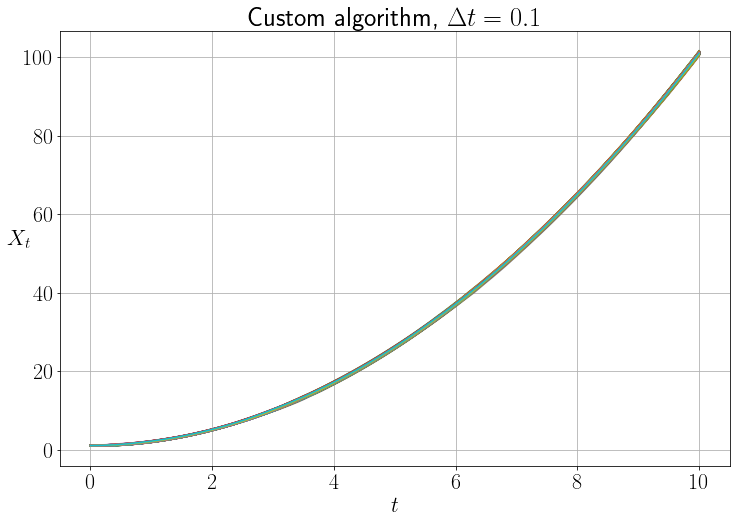

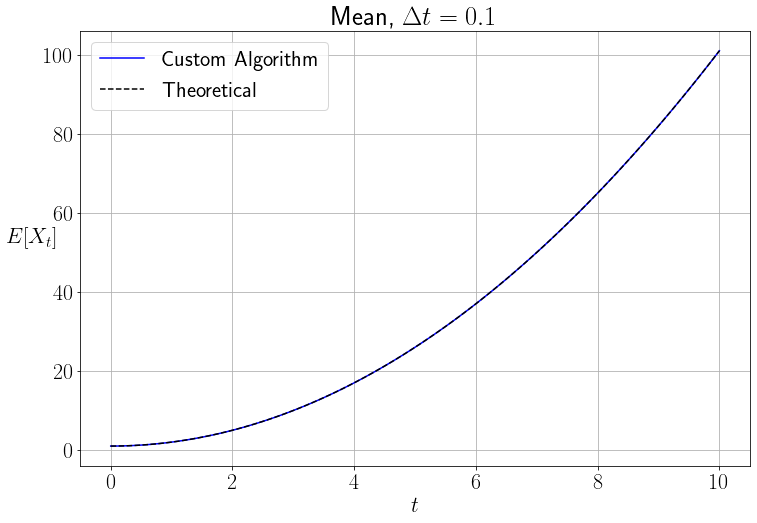

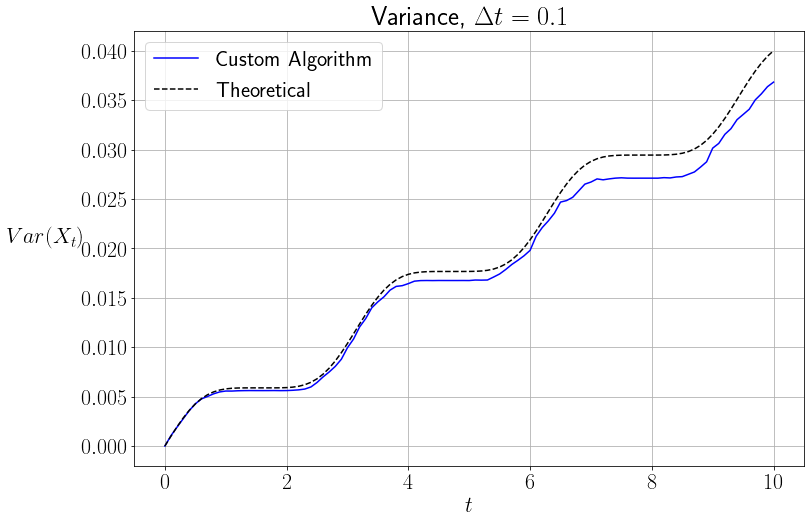

In [5]:
# Plotting simulations
fig = plt.figure(figsize=(12,8))
CStimes = np.arange(0, T+dt, dt)

for i in range(Nsim):
    plt.plot(CStimes, XCS[i,:])
plt.xlabel('$t$')
plt.ylabel('$X_t$',rotation=0)
plt.title('Custom algorithm, $\Delta t = %.1f$' % dt)
plt.grid()

# Plotting means
fig = plt.figure(figsize=(12,8))

plt.plot(CStimes, CSmeans, 'b', label='Custom Algorithm')
plt.plot(CStimes, GPmean(CStimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$E[X_t]$', labelpad=10, rotation=0)
plt.legend(loc='best')
plt.title('Mean, $\Delta t = %.1f$' % dt)
plt.grid()

# Plotting variances
fig = plt.figure(figsize=(12,8))

plt.plot(CStimes, CSvars, 'b', label='Custom Algorithm')
plt.plot(CStimes, GPvar(CStimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$Var (X_t)$', labelpad=35, rotation=0)
plt.legend(loc='best')
plt.title('Variance, $\Delta t = %.1f$' % dt)
plt.grid()

All simulations of $X_t$ increase at a scale $\mathcal{O}(t^2)$ and follow a very similar trajectory as a result of the small variance. The simulated mean and variance closely follow their theoretical distributions, validating the custom algorithm above.

**Question 1(d)**

*Euler-Maruyama scheme*

\begin{equation}
    X_{t_{n+1}} = X_{t_n} + a(X_{t_n}) \Delta t + \sigma(X_{t_n}) \Delta B_{t_n}
\end{equation}

where $\Delta B_{t_n} = \sqrt{\Delta t} \xi, \; \xi \sim \mathcal{N}(0,1)$ and $\alpha(X_{t}), \sigma(X_{t})$ are assumed to not change drastically in small time intervals.

We have

\begin{align*}
    a(X_{t_n}) &= \mu(t_n) = 2 t_n \\
    \sigma(X_{t_n}) &= \sigma(t_n) = 0.1 \cos^2 (t_n) .
\end{align*}

Hence, our scheme is

\begin{equation*}
    X_{t_{n+1}} = X_{t_n} + 2 t_n \Delta t + 0.1 \cos^2 (t_n) \sqrt{\Delta t} \xi .
\end{equation*}

In [6]:
def EulerMaruyama(X0, T, dt, Nsim):
    # function to simulate our Gaussian process using the EM scheme above, taking arguments:
    # X0: initial condition
    # T: final time to simulate until
    # dt: desired time step
    # Nsim: number of realizations
    
    t = np.arange(0, T+dt, dt)
    X = np.zeros((Nsim,len(t)))
    X[:,0] = X0
    
    # each row is a realization for times in (0,T)
    
    for i in range(Nsim):
        for j in range(len(t)-1):
            # scheme
            X[i,j+1] = X[i,j] + 2*t[j]*dt + 0.1*(np.cos(t[j]))**2*np.sqrt(dt)*np.random.normal(0,1)
        
    return X

In [7]:
# inputs
X0 = 1
T = 10
dt = 0.1
Nsim = 1000

# simulating
XEM = EulerMaruyama(X0, T, dt, Nsim)

EMsteps = np.shape(XEM)[1]

# means as a function of time
EMmeans = np.zeros(EMsteps)

# variances as a function of time
EMvars = np.zeros(EMsteps)

for k in range(EMsteps):
    EMmeans[k] = XEM[:,k].mean()
    EMvars[k] = variance(XEM[:,k])

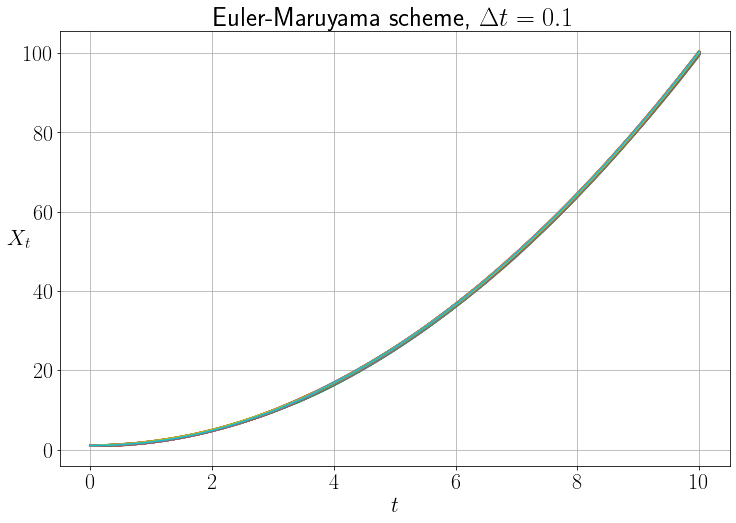

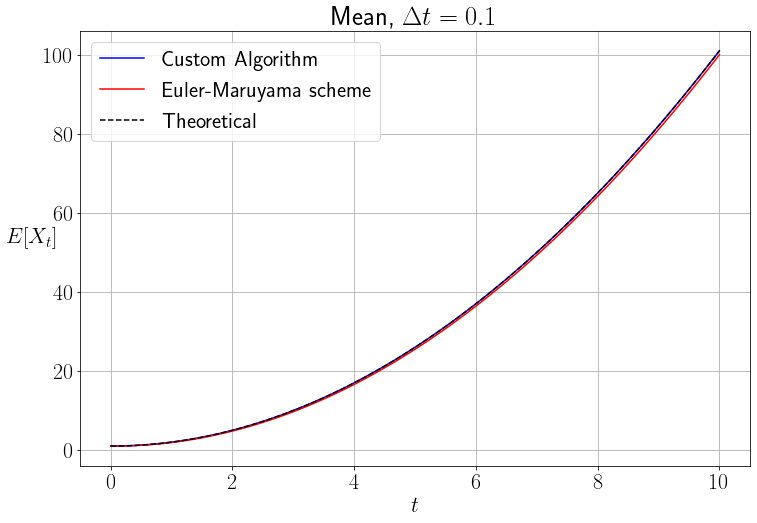

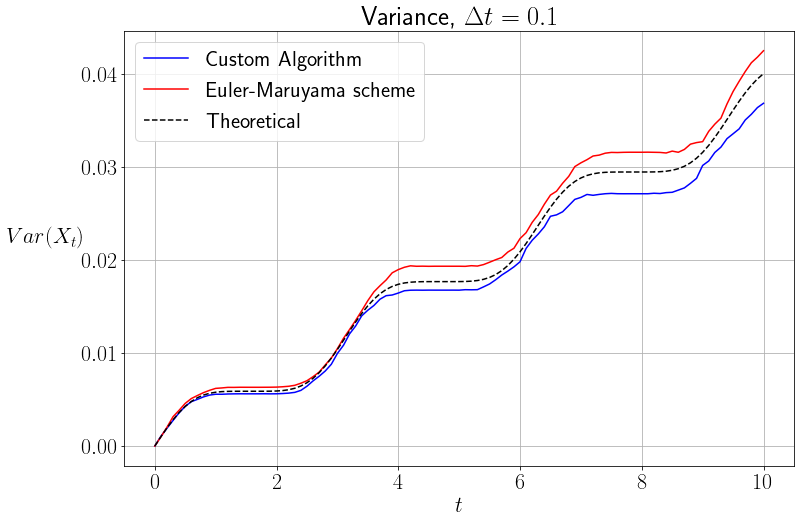

In [8]:
# Plotting simulations
fig = plt.figure(figsize=(12,8))
EMtimes = np.arange(0, T+dt, dt)

for i in range(Nsim):
    plt.plot(EMtimes, XEM[i,:])
plt.xlabel('$t$')
plt.ylabel('$X_t$',rotation=0)
plt.title('Euler-Maruyama scheme, $\Delta t = %.1f$' % dt)
plt.grid()

# Plotting means
fig = plt.figure(figsize=(12,8))

plt.plot(CStimes, CSmeans, 'b', label='Custom Algorithm')
plt.plot(EMtimes, EMmeans, 'r', label='Euler-Maruyama scheme')
plt.plot(CStimes, GPmean(CStimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$E[X_t]$', labelpad=10, rotation=0)
plt.legend(loc='best')
plt.title('Mean, $\Delta t = %.1f$' % dt)
plt.grid()

# Plotting variances
fig = plt.figure(figsize=(12,8))

plt.plot(CStimes, CSvars, 'b', label='Custom Algorithm')
plt.plot(EMtimes, EMvars, 'r', label='Euler-Maruyama scheme')
plt.plot(CStimes, GPvar(CStimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$Var (X_t)$', labelpad=35, rotation=0)
plt.legend(loc='best')
plt.title('Variance, $\Delta t = %.1f$' % dt)
plt.grid()

For the Euler-Maruyama scheme we witness simulations of $X_t$ also scale at $\mathcal{O}(t^2)$ with narrow variance. Comparing the trajectories of the sample mean and variance with those from the custom algorithm and their corresponding theoretical distributions shows that the Euler-Maruyama scheme follows a theoretical trajectory to a slightly less accurate degree than the custom algorithm. This discrepancy is a result of the Euler-Maruyama scheme relying on numerical approximations for the drift and diffusion terms in their integral form.

**Question 2(c)**

*Euler-Maruyama scheme*

\begin{equation}
    X_{t_{n+1}} = X_{t_n} + a(X_{t_n}) \Delta t + \sigma(X_{t_n}) \Delta B_{t_n}
\end{equation}

where $\Delta B_{t_n} = \sqrt{\Delta t} \xi, \; \xi \sim \mathcal{N}(0,1)$ and $\alpha(X_{t}), \sigma(X_{t})$ are assumed to not change drastically in small time intervals.

The SDE for the Ornstein-Uhlenbeck process is

\begin{equation}
    d X_t = - \alpha X_t dt + \sigma d B_t, \; X_0 = x_0 .
\end{equation}

with $a(X_{t_n}) = - \alpha X_{t_n}$ and $\sigma(X_{t_n}) = \sigma$ we arrive at the scheme

\begin{equation}
    X_{t_{n+1}} = X_{t_n}(1 - \alpha \Delta t) + \sigma \sqrt{\Delta t} \xi .
\end{equation}

In [9]:
def EM_OU(alpha, sigma, X0, T, dt, Nsim):
    # function to simulate an Ornstein-Uhlenbeck process using the scheme above, taking arguments:
    # alpha, sigma: constants
    # X0: initial condition
    # T: final time to simulate until
    # dt: desired time step
    # Nsim: number of realizations
    
    t = np.arange(0, T+dt, dt)
    X = np.zeros((Nsim,len(t)))
    X[:,0] = X0
    
    # each row is a realization for times in (0,T)
    
    for i in range(Nsim):
        for j in range(len(t)-1):
            # scheme
            X[i,j+1] = X[i,j]*(1 - alpha*dt) + sigma*np.sqrt(dt)*np.random.normal(0,1)
        
    return X

In [10]:
# inputs
alpha = 1
sigma = 1
X0 = 5
T = 10
Nsim = 100

dtA = 0.1
dtB = 0.01

# simulating processes
XA = EM_OU(alpha, sigma, X0, T, dtA, Nsim)
XB = EM_OU(alpha, sigma, X0, T, dtB, Nsim)

Asteps = np.shape(XA)[1]
Bsteps = np.shape(XB)[1]

# means as a function of time
Ameans = np.zeros(Asteps)
Bmeans = np.zeros(Bsteps)

# variances as a function of time
Avars = np.zeros(Asteps)
Bvars = np.zeros(Bsteps)

for k in range(Asteps):
    Ameans[k] = XA[:,k].mean()
    Avars[k] = variance(XA[:,k])

for l in range(Bsteps):
    Bmeans[l] = XB[:,l].mean()
    Bvars[l] = variance(XB[:,l])

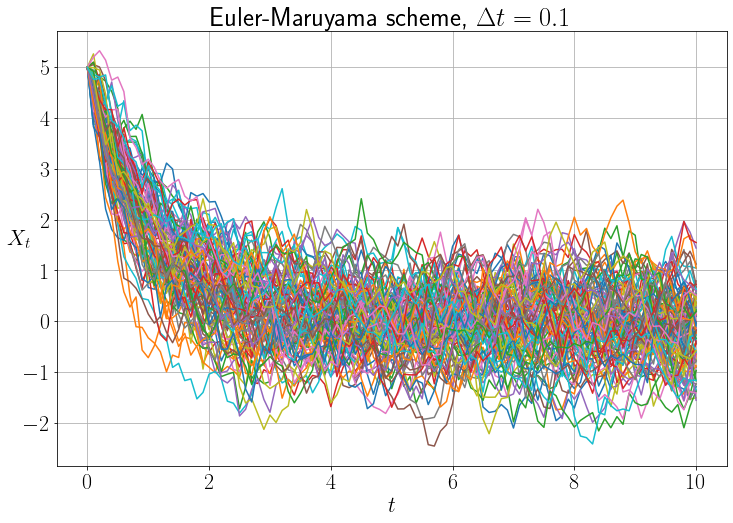

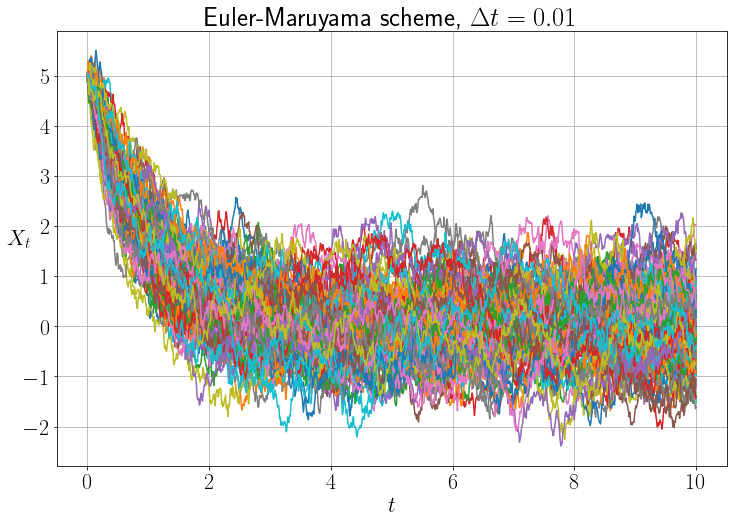

In [11]:
# Plotting simulations
fig = plt.figure(figsize=(12,8))
Atimes = np.arange(0, T+dtA, dtA)

for i in range(Nsim):
    plt.plot(Atimes, XA[i,:])
plt.xlabel('$t$')
plt.ylabel('$X_t$',rotation=0)
plt.title('Euler-Maruyama scheme, $\Delta t = %.1f$' % dtA)
plt.grid()

fig = plt.figure(figsize=(12,8))
Btimes = np.arange(0, T+dtB, dtB)

for i in range(Nsim):
    plt.plot(Btimes, XB[i,:])
plt.xlabel('$t$')
plt.ylabel('$X_t$',rotation=0)
plt.title('Euler-Maruyama scheme, $\Delta t = %.2f$' % dtB)
plt.grid()

In [12]:
# theoretical mean and variance from (b)
def OUmean(t):
    return X0*np.exp(-alpha*t)

def OUvar(t):
    return (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))

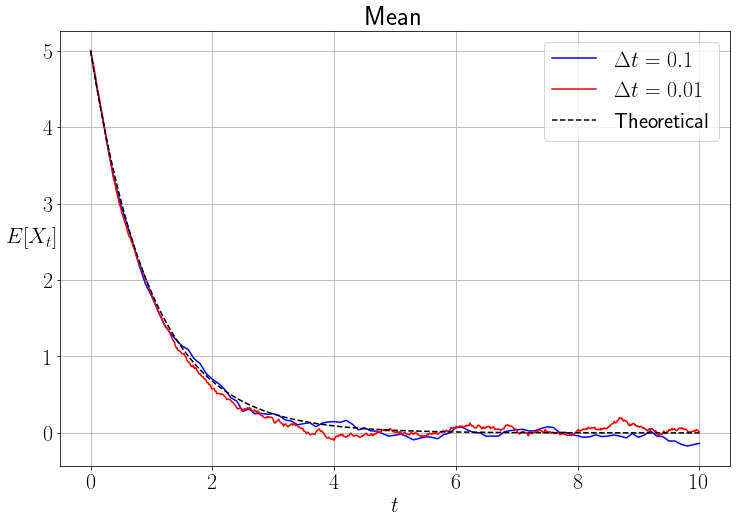

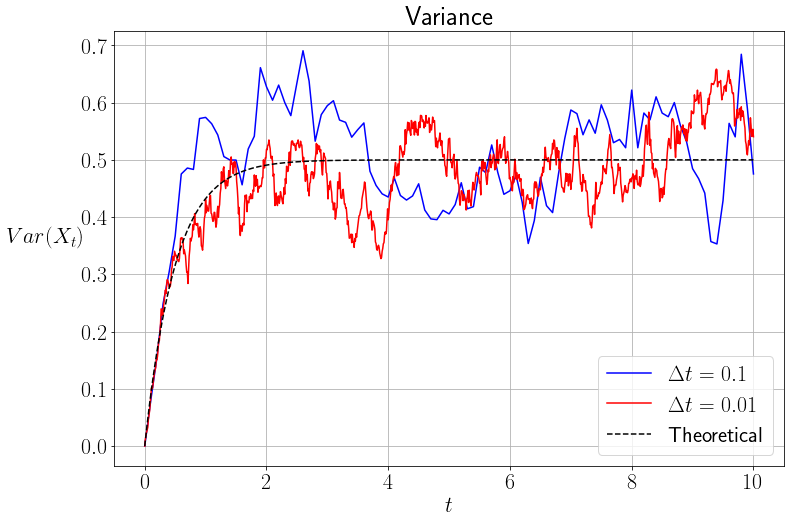

In [13]:
# Plotting means
fig = plt.figure(figsize=(12,8))

plt.plot(Atimes, Ameans, 'b', label='$\Delta t = %.1f$' % dtA)
plt.plot(Btimes, Bmeans, 'r', label='$\Delta t = %.2f$' % dtB)
plt.plot(Btimes, OUmean(Btimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$E[X_t]$', labelpad=10, rotation=0)
plt.legend(loc='best')
plt.title('Mean')
plt.grid()

# Plotting variances
fig = plt.figure(figsize=(12,8))

plt.plot(Atimes, Avars, 'b', label='$\Delta t = %.1f$' % dtA)
plt.plot(Btimes, Bvars, 'r', label='$\Delta t = %.2f$' % dtB)
plt.plot(Btimes, OUvar(Btimes), 'k--', label='Theoretical')
plt.xlabel('$t$')
plt.ylabel('$Var (X_t)$', labelpad=35, rotation=0)
plt.legend(loc='best')
plt.title('Variance')
plt.grid()

Simulating $X_t$ using the Euler-Maruyama scheme shows an exponential decay from initial condition $X_0 = 5$ down to a neighbourhood around zero, subject to small random truncations at each time step. The trajectories of the sample mean and variance clearly follow their theorectical distributions. Notably, this occurs for both time stepping discretisations $\Delta t = 0.1$ and $\Delta t = 0.01$ which shows that the Euler-Maruyama scheme is a reasonable approximation to the evolution of the process for at least $\Delta t \leq 0.1$.